# Classification of Image Data

## Libraries Importation 

In [123]:
# Import the libraries
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
from typing import List
from tqdm import tqdm
from random import sample
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [124]:
# Check if the pictures in the dataset are consistent in term of size
def size_check(dataset):
    dim_first_element = dataset[0].shape
    for element in range (1, len(dataset)):
        if dataset[element].shape != dim_first_element:
            return False
    return True

In [125]:
# Create a function to import the datasets automatically with or without normalization
def data_import(normalize = True):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    
    if size_check(x_train):
        x_train = x_train.reshape((x_train.shape[0], (x_train[0].shape)[0] * (x_train[0].shape)[1]))
    else:
        print("Image sizes are not consistent")
    
    if size_check(x_test):
        x_test = x_test.reshape((x_test.shape[0], (x_test[0].shape)[0] * (x_test[0].shape)[1]))
    else:
        print("Image sizes are not consistent")
    

    x_train = x_train/255
    x_test = x_test/255
    if normalize == True:
        x_train = (x_train - np.average(x_train)) / np.std(x_train)
        x_test = (x_test - np.average(x_test)) / np.std(x_test)
    return pd.DataFrame(x_train), pd.DataFrame(y_train), pd.DataFrame(x_test), pd.DataFrame(y_test)

In [126]:
# Input the class names associated to the dataset and create a dictionary linking every number to a category
class_name = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']).T
dic_class = {}
for i,name in enumerate(class_name):
    dic_class[i] = name
dic_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [127]:
# Import the normalized datasets
x_train, y_train, x_test, y_test = data_import(normalize = True)
y_train.columns= ['Class']
y_test.columns= ['Class']
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [128]:
# Create a function able to take any element in the vectorized x dataset and display the corresponding image
def visualize(vector, size1, size2):
    vector = vector.reshape((size1, size2))*255
    plt.imshow(vector, cmap='gray', vmin=0, vmax=255)
    plt.show()

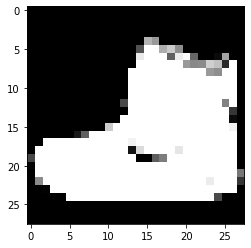

In [129]:
# Test the function on the first element of the normalized training dataset
vector = x_train.iloc[0,:].to_numpy()
visualize(vector, int(np.sqrt(len(vector))), int(np.sqrt(len(vector))))

## Model implementation

In [131]:
# Create the parent class for the layer types of the MLP
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

In [132]:
# Create some children classes of the NeuralNetLayer class
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size

        self.w = np.random.randn(output_size, input_size)*np.sqrt(2/input_size)
#         loc, scale = 0, 1
#         self.w = np.random.laplace(loc, scale, (output_size, input_size))*0.01 # we also tried to use a Laplace distribution
        self.b = np.random.randn(output_size)
        self.last_input = None
        self.parameters = [self.w, self.b]
  

    def forward(self, x):
        self.last_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        dw = gradient[:, :, None] @ self.last_input[:, None, :]
        db = 1 * gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        return gradient * self.gradient

class LeakyReLULayer(NeuralNetLayer):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0) + self.alpha * np.where(x < 0, 1.0, 0.0)
        return np.maximum(0, x) + self.alpha * np.minimum(0, x)

    def backward(self, gradient):
        return gradient * self.gradient    
    
class TanHLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.gradient = np.array([1 - ((np.exp(i) - np.exp(-i))/(np.exp(i) + np.exp(-i)))**2 for i in x])
        return np.array([(np.exp(i) - np.exp(-i))/(np.exp(i) + np.exp(-i)) for i in x])

    def backward(self, gradient):
        return gradient * self.gradient    

class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.last_probs = None

    def forward(self, x):
        #exps = np.exp((x - np.max(x)))
        exps = np.exp(x - np.max(x, axis=-1,keepdims=True))
        probs = exps / np.sum(exps, axis=-1)[:, None]
        #probs = x + np.log(np.sum(exps, axis=-1, keepdims=True))[:, None]
        self.last_probs = probs
        return self.last_probs
    
    def backward(self, y_real):
        return self.last_probs - y_real

In [133]:
# Create the MLP class
class MLP:
    def __init__(self, *args: List[NeuralNetLayer], batch_size):
        self.layers = args
        self.batch_size=batch_size
        self.predictions_train = None
        self.predictions_train_total = None
        self.predictions_test = None
        self.epoch_accuracy_train = []
        self.epoch_accuracy_test = []
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)
            
    def fit(self, optimizer, x_train, y_train, x_test, y_test, epochs, nb_labels):
        losses_train = []
        losses_test = []
        self.epoch_accuracy_train = []
        self.epoch_accuracy_test = [] 
        x_train_epoch = []
        y_train_epoch = []
        labels_train = np.eye(nb_labels)[np.array(y_train)]
        labels_test = np.eye(nb_labels)[np.array(y_test)]     
        
        for epoch in tqdm(range(epochs)):
            
            # Partition x_train into a number of batches according to batch size
            rand_index = np.random.permutation(x_train.shape[0]) 
            batch_num = math.ceil(len(rand_index)/self.batch_size) 
            batches = [rand_index[i:i + self.batch_size] for i in range(0, len(rand_index), self.batch_size)]
            
            # Traverse each batch until all train samples are covered
            for batch_index in batches:
                x_train_batch = np.array([x_train[index] for index in batch_index[:]])[::]
                y_train_batch = np.array([y_train[index] for index in batch_index[:]])[::]
            
                labels_train_batch = np.eye(nb_labels)[np.array(y_train_batch)]

                self.predictions_train = self.forward(x_train_batch)
                
                # The mean loss of each batch
                loss_train = -(labels_train_batch * np.log(self.predictions_train)).sum(axis=-1).mean()
                # loss_train = -(labels_train_batch * np.log1p(self.predictions_train-1)).sum(axis=-1).mean()
                
                # Backpropagating the error
                self.backward(labels_train_batch)
                
                # Optimizing the parameters
                optimizer.step()

            # Compute and store the train-accuracy of each epoch
            self.predictions_train_total = self.forward(x_train)
            epoch_loss_train = -(labels_train * np.log(self.predictions_train_total)).sum(axis=-1).mean()
            losses_train.append(epoch_loss_train)
            
            # Compute and store the train-accuracy in current epoch
            accuracy_train = self.multiclass_accuracy(y_train, self.predictions_train_total, nb_labels)
            self.epoch_accuracy_train.append(accuracy_train)
                
            # Compute and store the test-loss in current epoch
            self.predictions_test = self.forward(x_test)
            epoch_loss_test = -(labels_test * np.log(self.predictions_test)).sum(axis=-1).mean()
            losses_test.append(epoch_loss_test)
            
            # Compute and store the test-accuracy in current epoch
            accuracy_test = self.multiclass_accuracy(y_test, self.predictions_test, nb_labels)
            self.epoch_accuracy_test.append(accuracy_test)
             
            print("epoch", epoch+1, "|loss_train", epoch_loss_train, "|accu-train", accuracy_train, "|accu-test", accuracy_test)    
   
        plt.plot(losses_train, label = "cross entropy loss on the train set")
        plt.plot(losses_test, label = "cross entropy loss on the test set")
        plt.legend(loc = 0)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()        
    
    def predict(self, x):
        self.predictions = self.forward(x)
        return self.predictions
       
    def multiclass_accuracy(self, y, y_pred, nb_labels):
        y = np.eye(nb_labels)[np.array(y)]
        accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
        accuracy = accuracy / y.shape[0]
        return accuracy  

In [134]:
# Create the optimizers parent class
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

In [135]:
# Create children classes of the Optimizer class
class StochasticGradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)
            
class GradientDescentRegularizedOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float, Lambda : float):
        super().__init__(net)
        self.lr = lr
        self.Lambda = Lambda

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * (g.mean(axis=0) + 2 * self.Lambda * p)

In [136]:
# Define the batch size
batch_size = 128

## Small Perturbation

In [16]:
# Check the gradient calculation with ReLU
mlp = MLP(LinearLayer(784, 12),
          ReLULayer(),
          LinearLayer(12, 12),
          ReLULayer(),
          LinearLayer(12, 10),
          SoftmaxOutputLayer(),
          batch_size=batch_size)
nb = 100
layer = 0
mlp.forward(x_train.to_numpy()[0:nb])
labels = np.eye(10)[y_train.to_numpy()[0:nb].ravel()]
mlp.backward(labels)
grad = mlp.layers[layer].gradient[0]
w = mlp.layers[layer].w
eps = 1e-5

mat_loss = np.zeros((w.shape[0],w.shape[1]))

for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        
        w_plus = w.copy()
        w_minus = w.copy() 
        
        w_plus[i][j] = eps + w[i][j]

        w_minus[i][j] = -eps + w[i][j]

        mlp.layers[layer].w = w_plus
        y_pred_plus = mlp.forward(x_train.to_numpy()[0:nb])
        loss_plus = -(labels*np.log1p(y_pred_plus-1)).sum(axis=-1).mean()

        mlp.layers[layer].w = w_minus
        y_pred_minus = mlp.forward(x_train.to_numpy()[0:nb])
        loss_minus = -(labels*np.log1p(y_pred_minus-1)).sum(axis=-1).mean()

        numeric = (loss_plus - loss_minus)/(2*eps)
        mat_loss[i][j] = numeric - grad.mean(axis=0)[i][j]
mat_loss.max()

4.690800610440693e-08

In [17]:
# Check the gradient calculation with tanh
mlp = MLP(LinearLayer(784, 12),
          TanHLayer(),
          LinearLayer(12, 12),
          TanHLayer(),
          LinearLayer(12, 10),
          SoftmaxOutputLayer(),
          batch_size=batch_size)
nb = 100
layer = 0
mlp.forward(x_train.to_numpy()[0:nb])
labels = np.eye(10)[y_train.to_numpy()[0:nb].ravel()]
mlp.backward(labels)
grad = mlp.layers[layer].gradient[0]
w = mlp.layers[layer].w
eps = 1e-5

mat_loss = np.zeros((w.shape[0],w.shape[1]))

for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        
        w_plus = w.copy()
        w_minus = w.copy() 
        
        w_plus[i][j] = eps + w[i][j]

        w_minus[i][j] = -eps + w[i][j]

        mlp.layers[layer].w = w_plus
        y_pred_plus = mlp.forward(x_train.to_numpy()[0:nb])
        loss_plus = -(labels*np.log1p(y_pred_plus-1)).sum(axis=-1).mean()

        mlp.layers[layer].w = w_minus
        y_pred_minus = mlp.forward(x_train.to_numpy()[0:nb])
        loss_minus = -(labels*np.log1p(y_pred_minus-1)).sum(axis=-1).mean()

        numeric = (loss_plus - loss_minus)/(2*eps)
        mat_loss[i][j] = numeric - grad.mean(axis=0)[i][j]
mat_loss.max()

1.186980375100788e-10

In [18]:
# Check the gradient calculation with Leaky ReLU
mlp = MLP(LinearLayer(784, 12),
          LeakyReLULayer(alpha=0.01),
          LinearLayer(12, 12),
          LeakyReLULayer(alpha=0.01),
          LinearLayer(12, 10),
          SoftmaxOutputLayer(),
          batch_size=batch_size)
nb = 100
layer = 0
mlp.forward(x_train.to_numpy()[0:nb])
labels = np.eye(10)[y_train.to_numpy()[0:nb].ravel()]
mlp.backward(labels)
grad = mlp.layers[layer].gradient[0]
w = mlp.layers[layer].w
eps = 1e-5

mat_loss = np.zeros((w.shape[0],w.shape[1]))
 
for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        
        w_plus = w.copy()
        w_minus = w.copy() 
        
        w_plus[i][j] = eps + w[i][j]

        w_minus[i][j] = -eps + w[i][j]

        mlp.layers[layer].w = w_plus
        y_pred_plus = mlp.forward(x_train.to_numpy()[0:nb])
        loss_plus = -(labels*np.log1p(y_pred_plus-1)).sum(axis=-1).mean()

        mlp.layers[layer].w = w_minus
        y_pred_minus = mlp.forward(x_train.to_numpy()[0:nb])
        loss_minus = -(labels*np.log1p(y_pred_minus-1)).sum(axis=-1).mean()

        numeric = (loss_plus - loss_minus)/(2*eps)
        mat_loss[i][j] = numeric - grad.mean(axis=0)[i][j]
mat_loss.max()

1.8600000706303632e-10

# Different MLP Implementations

## Model 1: MLP with no hidden layer

  7%|▋         | 1/15 [00:02<00:28,  2.02s/it]

epoch 1 |loss_train 0.5738821487161382 |accu-train 0.798 |accu-test 0.7888


 13%|█▎        | 2/15 [00:03<00:25,  1.95s/it]

epoch 2 |loss_train 0.5153090533507478 |accu-train 0.8210833333333334 |accu-test 0.8099


 20%|██        | 3/15 [00:05<00:23,  1.93s/it]

epoch 3 |loss_train 0.4881590261845473 |accu-train 0.8314 |accu-test 0.8208


 27%|██▋       | 4/15 [00:07<00:20,  1.90s/it]

epoch 4 |loss_train 0.4726010522428041 |accu-train 0.8372166666666667 |accu-test 0.8259


 33%|███▎      | 5/15 [00:09<00:18,  1.87s/it]

epoch 5 |loss_train 0.46115822281450664 |accu-train 0.8407166666666667 |accu-test 0.8265


 40%|████      | 6/15 [00:11<00:16,  1.86s/it]

epoch 6 |loss_train 0.4544043644533785 |accu-train 0.8429333333333333 |accu-test 0.828


 47%|████▋     | 7/15 [00:13<00:14,  1.87s/it]

epoch 7 |loss_train 0.44450293341096014 |accu-train 0.84705 |accu-test 0.8322


 53%|█████▎    | 8/15 [00:15<00:13,  1.87s/it]

epoch 8 |loss_train 0.44286741025845344 |accu-train 0.8473166666666667 |accu-test 0.832


 60%|██████    | 9/15 [00:16<00:11,  1.86s/it]

epoch 9 |loss_train 0.4350414277917906 |accu-train 0.8503166666666667 |accu-test 0.8344


 67%|██████▋   | 10/15 [00:18<00:09,  1.86s/it]

epoch 10 |loss_train 0.4310670569184855 |accu-train 0.8518 |accu-test 0.8357


 73%|███████▎  | 11/15 [00:20<00:07,  1.85s/it]

epoch 11 |loss_train 0.42822479705199773 |accu-train 0.8529166666666667 |accu-test 0.8334


 80%|████████  | 12/15 [00:22<00:05,  1.82s/it]

epoch 12 |loss_train 0.42472475732902265 |accu-train 0.8537 |accu-test 0.8359


 87%|████████▋ | 13/15 [00:24<00:03,  1.82s/it]

epoch 13 |loss_train 0.42272933625708836 |accu-train 0.8552 |accu-test 0.8378


 93%|█████████▎| 14/15 [00:25<00:01,  1.79s/it]

epoch 14 |loss_train 0.4187370916204496 |accu-train 0.8569166666666667 |accu-test 0.8369


100%|██████████| 15/15 [00:27<00:00,  1.85s/it]

epoch 15 |loss_train 0.41711993863833136 |accu-train 0.8562833333333333 |accu-test 0.8381


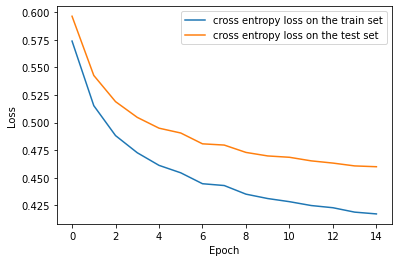

In [76]:
# Train the model
hidden_layers_size = 10
input_size = x_train.shape[1]
nb_labels = len(class_name)
mlp1 = MLP(LinearLayer(input_size, hidden_layers_size), 
    SoftmaxOutputLayer(), batch_size=128)
opt = StochasticGradientDescentOptimizer(mlp1, 0.01)
epoch = 15
mlp1.fit(opt, x_train.to_numpy(), y_train.to_numpy().ravel(), x_test.to_numpy(), y_test.to_numpy().ravel(), epoch, nb_labels)

In [77]:
# Predict on the train dataset
y_pred_train_model1 = mlp1.predict(x_train.to_numpy())

In [78]:
# Print the accuracy on the train dataset
print('Multiclass accuracy (train):', round(mlp1.multiclass_accuracy(y_train.to_numpy().ravel(),y_pred_train_model1, nb_labels)*100,2), '%')

Multiclass accuracy (train): 85.63 %


In [79]:
# Predict on the test dataset
y_pred_test_model1 = mlp1.predict(x_test.to_numpy())

In [80]:
# Print the accuracy on the test dataset
print('Multiclass accuracy (test):', round(mlp1.multiclass_accuracy(y_test.to_numpy().ravel(),y_pred_test_model1, nb_labels)*100,2), '%')

Multiclass accuracy (test): 83.81 %


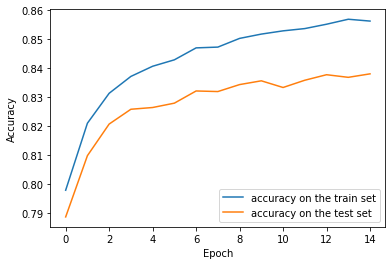

In [81]:
# Plot the evolution of the accuracy over the epochs
plt.plot(mlp1.epoch_accuracy_train, label = "accuracy on the train set")
plt.plot(mlp1.epoch_accuracy_test, label = "accuracy on the test set")
plt.legend(loc = 0)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Model 2: MLP with a single hidden layer having 128 units and ReLU activations

  7%|▋         | 1/15 [00:18<04:17, 18.41s/it]

epoch 1 |loss_train 0.5462793757400122 |accu-train 0.8065666666666667 |accu-test 0.7947


 13%|█▎        | 2/15 [00:36<03:59, 18.43s/it]

epoch 2 |loss_train 0.47438979494052935 |accu-train 0.83425 |accu-test 0.8188


 20%|██        | 3/15 [00:55<03:39, 18.32s/it]

epoch 3 |loss_train 0.44325144945226 |accu-train 0.84355 |accu-test 0.8292


 27%|██▋       | 4/15 [01:13<03:20, 18.23s/it]

epoch 4 |loss_train 0.42556766458659595 |accu-train 0.8497833333333333 |accu-test 0.8364


 33%|███▎      | 5/15 [01:32<03:05, 18.57s/it]

epoch 5 |loss_train 0.4060540951441106 |accu-train 0.8569666666666667 |accu-test 0.841


 40%|████      | 6/15 [01:52<02:50, 18.96s/it]

epoch 6 |loss_train 0.39470700839526446 |accu-train 0.8607666666666667 |accu-test 0.8455


 47%|████▋     | 7/15 [02:11<02:32, 19.10s/it]

epoch 7 |loss_train 0.39115184643614 |accu-train 0.86005 |accu-test 0.842


 53%|█████▎    | 8/15 [02:30<02:12, 18.98s/it]

epoch 8 |loss_train 0.37801284874656516 |accu-train 0.8643333333333333 |accu-test 0.8461


 60%|██████    | 9/15 [02:49<01:54, 19.02s/it]

epoch 9 |loss_train 0.3708840139123451 |accu-train 0.8682666666666666 |accu-test 0.851


 67%|██████▋   | 10/15 [03:07<01:34, 18.83s/it]

epoch 10 |loss_train 0.36059996202760036 |accu-train 0.8714 |accu-test 0.8539


 73%|███████▎  | 11/15 [03:25<01:14, 18.58s/it]

epoch 11 |loss_train 0.3547051301829344 |accu-train 0.87375 |accu-test 0.8555


 80%|████████  | 12/15 [03:43<00:55, 18.47s/it]

epoch 12 |loss_train 0.34916045180783983 |accu-train 0.8755833333333334 |accu-test 0.8576


 87%|████████▋ | 13/15 [04:01<00:36, 18.30s/it]

epoch 13 |loss_train 0.34167019261397047 |accu-train 0.8782833333333333 |accu-test 0.8584


 93%|█████████▎| 14/15 [04:19<00:18, 18.25s/it]

epoch 14 |loss_train 0.33770485862432215 |accu-train 0.88055 |accu-test 0.8588


100%|██████████| 15/15 [04:37<00:00, 18.53s/it]

epoch 15 |loss_train 0.3355666177631649 |accu-train 0.881 |accu-test 0.8617


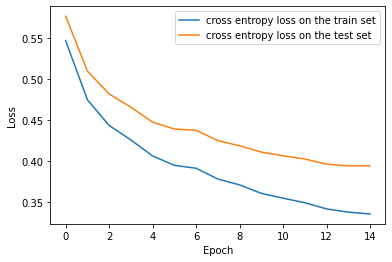

In [82]:
# Train the model
hidden_layers_size = 128
input_size = x_train.shape[1]
nb_labels = len(class_name)
mlp2 = MLP(LinearLayer(input_size, hidden_layers_size), 
    ReLULayer(),
    LinearLayer(hidden_layers_size, nb_labels),
    SoftmaxOutputLayer(),
    batch_size=128)
opt = StochasticGradientDescentOptimizer(mlp2, 0.01)
epoch = 15
mlp2.fit(opt, x_train.to_numpy(), y_train.to_numpy().ravel(), x_test.to_numpy(), y_test.to_numpy().ravel(), epoch, nb_labels)

In [83]:
# Predict on the train dataset
y_pred_train_model2 = mlp2.predict(x_train.to_numpy())

In [84]:
# Print the accuracy on the train dataset
print('Multiclass accuracy (train):', round(mlp2.multiclass_accuracy(y_train.to_numpy().ravel(),y_pred_train_model2, nb_labels)*100,2), '%')

Multiclass accuracy (train): 88.1 %


In [85]:
# Predict on the test dataset
y_pred_test_model2 = mlp2.predict(x_test.to_numpy())

In [86]:
# Print the accuracy on the test dataset
print('Multiclass accuracy (test):', round(mlp2.multiclass_accuracy(y_test.to_numpy().ravel(),y_pred_test_model2, nb_labels)*100,2), '%')

Multiclass accuracy (test): 86.17 %


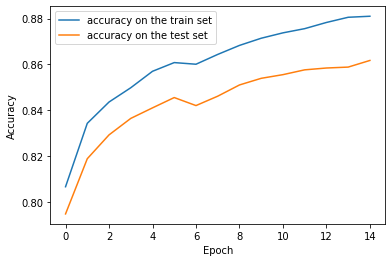

In [87]:
# Plot the evolution of the accuracy over the epochs
plt.plot(mlp2.epoch_accuracy_train, label = "accuracy on the train set")
plt.plot(mlp2.epoch_accuracy_test, label = "accuracy on the test set")
plt.legend(loc = 0)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Model 3: MLP with 2 hidden layers each having 128 units with ReLU activations.

  7%|▋         | 1/15 [00:21<04:56, 21.20s/it]

epoch 1 |loss_train 0.5064841235779048 |accu-train 0.8214666666666667 |accu-test 0.8126


 13%|█▎        | 2/15 [00:44<04:52, 22.52s/it]

epoch 2 |loss_train 0.455909130616047 |accu-train 0.8351333333333333 |accu-test 0.8241


 20%|██        | 3/15 [01:06<04:28, 22.39s/it]

epoch 3 |loss_train 0.4130754183479359 |accu-train 0.8532833333333333 |accu-test 0.8406


 27%|██▋       | 4/15 [01:29<04:07, 22.52s/it]

epoch 4 |loss_train 0.39108740051986235 |accu-train 0.8621833333333333 |accu-test 0.8479


 33%|███▎      | 5/15 [01:52<03:46, 22.62s/it]

epoch 5 |loss_train 0.37276878240791433 |accu-train 0.8673333333333333 |accu-test 0.8516


 40%|████      | 6/15 [02:14<03:21, 22.39s/it]

epoch 6 |loss_train 0.375724926723486 |accu-train 0.86505 |accu-test 0.8482


 47%|████▋     | 7/15 [02:36<02:59, 22.48s/it]

epoch 7 |loss_train 0.3546301914651064 |accu-train 0.8743833333333333 |accu-test 0.8561


 53%|█████▎    | 8/15 [02:58<02:36, 22.32s/it]

epoch 8 |loss_train 0.3396676985936484 |accu-train 0.8791833333333333 |accu-test 0.86


 60%|██████    | 9/15 [03:20<02:12, 22.03s/it]

epoch 9 |loss_train 0.3469020497116813 |accu-train 0.8750833333333333 |accu-test 0.8567


 67%|██████▋   | 10/15 [03:42<01:49, 21.91s/it]

epoch 10 |loss_train 0.3337416091513197 |accu-train 0.88 |accu-test 0.861


 73%|███████▎  | 11/15 [04:06<01:30, 22.63s/it]

epoch 11 |loss_train 0.3281081327754745 |accu-train 0.88205 |accu-test 0.864


 80%|████████  | 12/15 [04:30<01:09, 23.06s/it]

epoch 12 |loss_train 0.3170724291235374 |accu-train 0.8864166666666666 |accu-test 0.8654


 87%|████████▋ | 13/15 [04:53<00:46, 23.10s/it]

epoch 13 |loss_train 0.313343097484351 |accu-train 0.8884666666666666 |accu-test 0.8657


 93%|█████████▎| 14/15 [05:15<00:22, 22.76s/it]

epoch 14 |loss_train 0.30165464001546044 |accu-train 0.8922833333333333 |accu-test 0.8705


100%|██████████| 15/15 [05:38<00:00, 22.56s/it]

epoch 15 |loss_train 0.29748736472047305 |accu-train 0.89315 |accu-test 0.8707


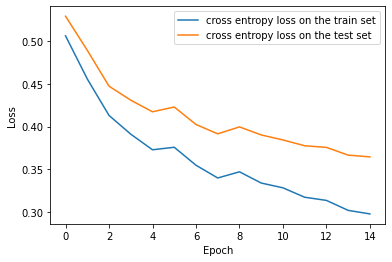

In [88]:
# Train the model
hidden_layers_size = 128
input_size = x_train.shape[1]
nb_labels = len(class_name)
mlp3 = MLP(LinearLayer(input_size, hidden_layers_size), 
    ReLULayer(),
    LinearLayer(hidden_layers_size, hidden_layers_size),
    ReLULayer(),
    LinearLayer(hidden_layers_size, nb_labels),
    SoftmaxOutputLayer(),
        batch_size=128)
opt = StochasticGradientDescentOptimizer(mlp3, 0.01)
epoch = 15
mlp3.fit(opt, x_train.to_numpy(), y_train.to_numpy().ravel(), x_test.to_numpy(), y_test.to_numpy().ravel(), epoch, nb_labels)

In [89]:
# Predict on the train dataset
y_pred_train_model3 = mlp3.predict(x_train.to_numpy())

In [90]:
# Print the accuracy on the train dataset
print('Multiclass accuracy (train):', round(mlp3.multiclass_accuracy(y_train.to_numpy().ravel(),y_pred_train_model3, nb_labels)*100,2), '%')

Multiclass accuracy (train): 89.32 %


In [91]:
# Predict on the test dataset
y_pred_test_model3 = mlp3.predict(x_test.to_numpy())

In [92]:
# Print the accuracy on the test dataset
print('Multiclass accuracy (train):', round(mlp3.multiclass_accuracy(y_test.to_numpy().ravel(),y_pred_test_model3, nb_labels)*100,2), '%')

Multiclass accuracy (train): 87.07 %


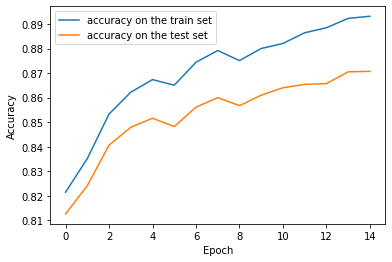

In [93]:
# Plot the evolution of the accuracy over the epochs
plt.plot(mlp3.epoch_accuracy_train, label = "accuracy on the train set")
plt.plot(mlp3.epoch_accuracy_test, label = "accuracy on the test set")
plt.legend(loc = 0)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Models with different activation functions

### Model 4 MLP with TanH activation function

  7%|▋         | 1/15 [00:28<06:41, 28.69s/it]

epoch 1 |loss_train 0.5033997568461627 |accu-train 0.8222833333333334 |accu-test 0.8124


 13%|█▎        | 2/15 [00:58<06:24, 29.59s/it]

epoch 2 |loss_train 0.4316919790361971 |accu-train 0.84605 |accu-test 0.8335


 20%|██        | 3/15 [01:28<05:55, 29.60s/it]

epoch 3 |loss_train 0.3931051478401096 |accu-train 0.8602166666666666 |accu-test 0.8445


 27%|██▋       | 4/15 [01:57<05:21, 29.25s/it]

epoch 4 |loss_train 0.37219499570406245 |accu-train 0.8661833333333333 |accu-test 0.8491


 33%|███▎      | 5/15 [02:26<04:53, 29.34s/it]

epoch 5 |loss_train 0.35265474593804264 |accu-train 0.8728833333333333 |accu-test 0.8542


 40%|████      | 6/15 [02:56<04:25, 29.48s/it]

epoch 6 |loss_train 0.3383951320357959 |accu-train 0.87875 |accu-test 0.8605


 47%|████▋     | 7/15 [03:24<03:53, 29.16s/it]

epoch 7 |loss_train 0.3265452913083749 |accu-train 0.8838166666666667 |accu-test 0.8635


 53%|█████▎    | 8/15 [03:53<03:21, 28.85s/it]

epoch 8 |loss_train 0.31625277046410855 |accu-train 0.8868833333333334 |accu-test 0.8676


 60%|██████    | 9/15 [04:22<02:53, 28.97s/it]

epoch 9 |loss_train 0.30766144633968634 |accu-train 0.8894666666666666 |accu-test 0.8665


 67%|██████▋   | 10/15 [04:50<02:23, 28.79s/it]

epoch 10 |loss_train 0.30535189132004537 |accu-train 0.8894666666666666 |accu-test 0.8683


 73%|███████▎  | 11/15 [05:18<01:53, 28.32s/it]

epoch 11 |loss_train 0.2905317728358958 |accu-train 0.8953 |accu-test 0.872


 80%|████████  | 12/15 [05:44<01:23, 27.71s/it]

epoch 12 |loss_train 0.28417131817282365 |accu-train 0.89855 |accu-test 0.8738


 87%|████████▋ | 13/15 [06:11<00:54, 27.50s/it]

epoch 13 |loss_train 0.2787246020718903 |accu-train 0.9003166666666667 |accu-test 0.8757


 93%|█████████▎| 14/15 [06:38<00:27, 27.39s/it]

epoch 14 |loss_train 0.2794637059531875 |accu-train 0.8987833333333334 |accu-test 0.8706


100%|██████████| 15/15 [07:06<00:00, 28.41s/it]

epoch 15 |loss_train 0.2677447801820594 |accu-train 0.9033166666666667 |accu-test 0.8754


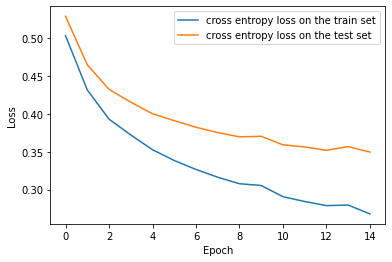

In [94]:
# Train the model
hidden_layers_size = 128
input_size = x_train.shape[1]
nb_labels = len(class_name)
mlp4 = MLP(LinearLayer(input_size, hidden_layers_size), 
    TanHLayer(),
    LinearLayer(hidden_layers_size, hidden_layers_size),
    TanHLayer(),
    LinearLayer(hidden_layers_size, nb_labels),
    SoftmaxOutputLayer(),
          batch_size=64)
opt = StochasticGradientDescentOptimizer(mlp4, 0.01)
epoch = 15
mlp4.fit(opt, x_train.to_numpy(), y_train.to_numpy().ravel(), x_test.to_numpy(), y_test.to_numpy().ravel(), epoch, nb_labels)

In [95]:
# Predict on the train dataset
y_pred_train_model4 = mlp4.predict(x_train.to_numpy())

In [96]:
# Print the accuracy on the train dataset
print('Multiclass accuracy (train):', round(mlp4.multiclass_accuracy(y_train.to_numpy().ravel(),y_pred_train_model4, nb_labels)*100,2), '%')

Multiclass accuracy (train): 90.33 %


In [97]:
# Predict on the test dataset
y_pred_test_model4 = mlp4.predict(x_test.to_numpy())

In [98]:
# Print the accuracy on the test dataset
print('Multiclass accuracy (test):', round(mlp4.multiclass_accuracy(y_test.to_numpy().ravel(),y_pred_test_model4, nb_labels)*100,2), '%')

Multiclass accuracy (test): 87.54 %


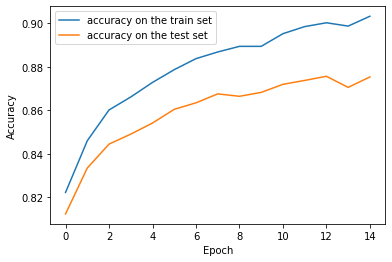

In [99]:
# Plot the evolution of the accuracy over the epochs
plt.plot(mlp4.epoch_accuracy_train, label = "accuracy on the train set")
plt.plot(mlp4.epoch_accuracy_test, label = "accuracy on the test set")
plt.legend(loc = 0)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### Model 5 MLP with Leaky-ReLU activation function

  7%|▋         | 1/15 [00:21<05:01, 21.57s/it]

epoch 1 |loss_train 0.488211694717507 |accu-train 0.8224 |accu-test 0.8098


 13%|█▎        | 2/15 [00:43<04:40, 21.58s/it]

epoch 2 |loss_train 0.41571759638283057 |accu-train 0.8503166666666667 |accu-test 0.8334


 20%|██        | 3/15 [01:04<04:19, 21.64s/it]

epoch 3 |loss_train 0.3751295193604846 |accu-train 0.8644833333333334 |accu-test 0.8499


 27%|██▋       | 4/15 [01:26<03:59, 21.75s/it]

epoch 4 |loss_train 0.3541073001294471 |accu-train 0.87075 |accu-test 0.8532


 33%|███▎      | 5/15 [01:48<03:37, 21.77s/it]

epoch 5 |loss_train 0.35762923130323604 |accu-train 0.8692833333333333 |accu-test 0.8526


 40%|████      | 6/15 [02:10<03:14, 21.66s/it]

epoch 6 |loss_train 0.3316897877960637 |accu-train 0.87995 |accu-test 0.859


 47%|████▋     | 7/15 [02:31<02:52, 21.62s/it]

epoch 7 |loss_train 0.3134071946672014 |accu-train 0.8863833333333333 |accu-test 0.8654


 53%|█████▎    | 8/15 [02:53<02:31, 21.60s/it]

epoch 8 |loss_train 0.3080732509711405 |accu-train 0.88775 |accu-test 0.864


 60%|██████    | 9/15 [03:14<02:09, 21.59s/it]

epoch 9 |loss_train 0.30069849804396537 |accu-train 0.8903 |accu-test 0.8653


 67%|██████▋   | 10/15 [03:36<01:48, 21.62s/it]

epoch 10 |loss_train 0.29977196232794584 |accu-train 0.89145 |accu-test 0.8661


 73%|███████▎  | 11/15 [03:57<01:26, 21.60s/it]

epoch 11 |loss_train 0.2851708239692386 |accu-train 0.8964166666666666 |accu-test 0.8695


 80%|████████  | 12/15 [04:19<01:04, 21.59s/it]

epoch 12 |loss_train 0.27107892738766365 |accu-train 0.9022666666666667 |accu-test 0.8729


 87%|████████▋ | 13/15 [04:41<00:43, 21.56s/it]

epoch 13 |loss_train 0.26595754618297257 |accu-train 0.9039 |accu-test 0.874


 93%|█████████▎| 14/15 [05:02<00:21, 21.55s/it]

epoch 14 |loss_train 0.2677100971566774 |accu-train 0.9001333333333333 |accu-test 0.8681


100%|██████████| 15/15 [05:24<00:00, 21.63s/it]

epoch 15 |loss_train 0.254912525107075 |accu-train 0.9078 |accu-test 0.8744


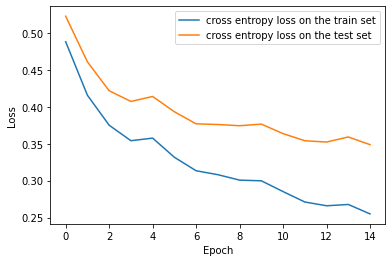

In [142]:
# Train the model
hidden_layers_size = 128
alpha=0.001
input_size = x_train.shape[1]
nb_labels = len(class_name)
mlp5 = MLP(LinearLayer(input_size, hidden_layers_size), 
    LeakyReLULayer(alpha),
    LinearLayer(hidden_layers_size, hidden_layers_size),
    LeakyReLULayer(alpha),
    LinearLayer(hidden_layers_size, nb_labels),
    SoftmaxOutputLayer(),batch_size=64)
opt = StochasticGradientDescentOptimizer(mlp5, 0.01)
epoch = 15
mlp5.fit(opt, x_train.to_numpy(), y_train.to_numpy().ravel(), x_test.to_numpy(), y_test.to_numpy().ravel(), epoch, nb_labels)

In [143]:
# Predict on the train dataset
y_pred_train_model5 = mlp5.predict(x_train.to_numpy())

In [144]:
# Print the accuracy on the train dataset
print('Multiclass accuracy (train):', round(mlp5.multiclass_accuracy(y_train.to_numpy().ravel(),y_pred_train_model5, nb_labels)*100,2), '%')

Multiclass accuracy (train): 90.78 %


In [145]:
# Predict on the test dataset
y_pred_test_model5 = mlp5.predict(x_test.to_numpy())

In [146]:
# Print the accuracy on the test dataset
print('Multiclass accuracy (test):', round(mlp5.multiclass_accuracy(y_test.to_numpy().ravel(),y_pred_test_model5, nb_labels)*100,2), '%')

Multiclass accuracy (test): 87.44 %


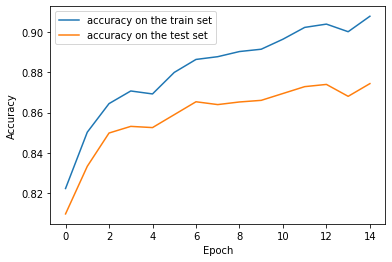

In [147]:
# Plot the evolution of the accuracy over the epochs
plt.plot(mlp5.epoch_accuracy_train, label = "accuracy on the train set")
plt.plot(mlp5.epoch_accuracy_test, label = "accuracy on the test set")
plt.legend(loc = 0)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Model 6 MLP with L2 regularization

  7%|▋         | 1/15 [00:22<05:16, 22.62s/it]

epoch 1 |loss_train 0.5144945427389075 |accu-train 0.81605 |accu-test 0.8082


 13%|█▎        | 2/15 [00:45<04:56, 22.78s/it]

epoch 2 |loss_train 0.4473469066585484 |accu-train 0.8411 |accu-test 0.8294


 20%|██        | 3/15 [01:08<04:36, 23.07s/it]

epoch 3 |loss_train 0.4172746595436399 |accu-train 0.8524333333333334 |accu-test 0.8366


 27%|██▋       | 4/15 [01:32<04:15, 23.24s/it]

epoch 4 |loss_train 0.3979363148600966 |accu-train 0.8594666666666667 |accu-test 0.8414


 33%|███▎      | 5/15 [01:54<03:49, 22.99s/it]

epoch 5 |loss_train 0.38233767455968665 |accu-train 0.8642 |accu-test 0.8448


 40%|████      | 6/15 [02:18<03:29, 23.28s/it]

epoch 6 |loss_train 0.37355155702821796 |accu-train 0.86795 |accu-test 0.8452


 47%|████▋     | 7/15 [02:44<03:11, 23.94s/it]

epoch 7 |loss_train 0.3642844786168664 |accu-train 0.8706333333333334 |accu-test 0.8527


 53%|█████▎    | 8/15 [03:06<02:44, 23.45s/it]

epoch 8 |loss_train 0.3533852123970765 |accu-train 0.8748 |accu-test 0.8536


 60%|██████    | 9/15 [03:28<02:17, 22.89s/it]

epoch 9 |loss_train 0.34720027745292864 |accu-train 0.8775 |accu-test 0.8586


 67%|██████▋   | 10/15 [03:50<01:52, 22.57s/it]

epoch 10 |loss_train 0.33886965724768914 |accu-train 0.8791333333333333 |accu-test 0.8587


 73%|███████▎  | 11/15 [04:12<01:30, 22.57s/it]

epoch 11 |loss_train 0.3329495583349462 |accu-train 0.8831333333333333 |accu-test 0.8613


 80%|████████  | 12/15 [04:34<01:07, 22.49s/it]

epoch 12 |loss_train 0.3277990130810733 |accu-train 0.8840333333333333 |accu-test 0.8606


 87%|████████▋ | 13/15 [04:58<00:45, 22.79s/it]

epoch 13 |loss_train 0.325975999283528 |accu-train 0.8846 |accu-test 0.8603


 93%|█████████▎| 14/15 [05:20<00:22, 22.53s/it]

epoch 14 |loss_train 0.324564126971258 |accu-train 0.8829333333333333 |accu-test 0.8618


100%|██████████| 15/15 [05:41<00:00, 22.78s/it]

epoch 15 |loss_train 0.3150271989958413 |accu-train 0.8882333333333333 |accu-test 0.8634


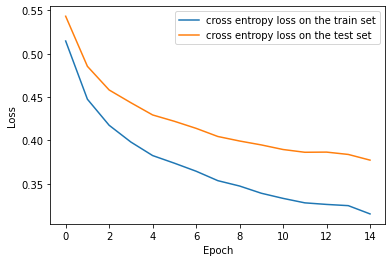

In [114]:
# Train the model
hidden_layers_size = 128
Lambda=0.001
#Lambda=0.01
#Lambda=0.1
input_size = x_train.shape[1]
nb_labels = len(class_name)
mlp6 = MLP(LinearLayer(input_size, hidden_layers_size), 
    ReLULayer(),
    LinearLayer(hidden_layers_size, hidden_layers_size),
    ReLULayer(),
    LinearLayer(hidden_layers_size, nb_labels),
    SoftmaxOutputLayer(),
          batch_size=64)
opt = GradientDescentRegularizedOptimizer(mlp6, 0.005, Lambda)
epoch = 15
mlp6.fit(opt, x_train.to_numpy(), y_train.to_numpy().ravel(), x_test.to_numpy(), y_test.to_numpy().ravel(), epoch, nb_labels)

In [115]:
# Predict on the train dataset
y_pred_train_model6 = mlp6.predict(x_train.to_numpy())

In [116]:
# Print the accuracy on the train dataset
print('Multiclass accuracy (train):', round(mlp6.multiclass_accuracy(y_train.to_numpy().ravel(),y_pred_train_model6, nb_labels)*100,2), '%')

Multiclass accuracy (train): 88.82 %


In [117]:
# Predict on the test dataset
y_pred_test_model6 = mlp6.predict(x_test.to_numpy())

In [118]:
# Print the accuracy on the test dataset
print('Multiclass accuracy (test):', round(mlp6.multiclass_accuracy(y_test.to_numpy().ravel(),y_pred_test_model6, nb_labels)*100,2), '%')

Multiclass accuracy (test): 86.34 %


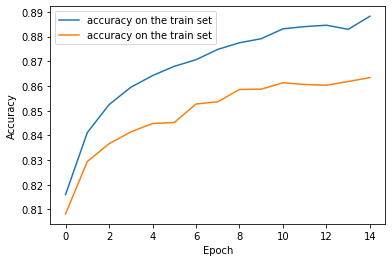

In [119]:
# Plot the evolution of the accuracy over the epochs
plt.plot(mlp6.epoch_accuracy_train, label = "accuracy on the train set")
plt.plot(mlp6.epoch_accuracy_test, label = "accuracy on the train set")
plt.legend(loc = 0)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Model 7 MLP with unnormalized images

In [15]:
# Import the unnormalized datasets
x_train_un, y_train, x_test_un, y_test = data_import(normalize = False)
y_test.columns= ['Class']
y_train.columns= ['Class']

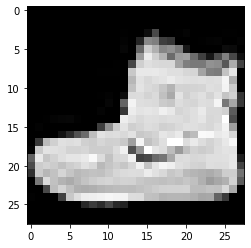

In [16]:
# Plot the first element of the unormalized training dataset
vector = x_train_un.iloc[0,:].to_numpy()
visualize(vector, int(np.sqrt(len(vector))), int(np.sqrt(len(vector))))

  7%|▋         | 1/15 [00:23<05:35, 23.99s/it]

epoch 1 |loss_train 0.6629218333241991 |accu-train 0.7691666666666667 |accu-test 0.7613


 13%|█▎        | 2/15 [00:45<04:54, 22.68s/it]

epoch 2 |loss_train 0.5662291411204932 |accu-train 0.7993166666666667 |accu-test 0.7897


 20%|██        | 3/15 [01:07<04:27, 22.29s/it]

epoch 3 |loss_train 0.5132027818799084 |accu-train 0.8182833333333334 |accu-test 0.8094


 27%|██▋       | 4/15 [01:29<04:03, 22.11s/it]

epoch 4 |loss_train 0.4922364619577058 |accu-train 0.8256833333333333 |accu-test 0.8154


 33%|███▎      | 5/15 [01:51<03:39, 21.96s/it]

epoch 5 |loss_train 0.46844238174820074 |accu-train 0.8355166666666667 |accu-test 0.8231


 40%|████      | 6/15 [02:13<03:17, 21.99s/it]

epoch 6 |loss_train 0.45159193971343925 |accu-train 0.84085 |accu-test 0.8269


 47%|████▋     | 7/15 [02:35<02:55, 21.99s/it]

epoch 7 |loss_train 0.4405971422602377 |accu-train 0.84455 |accu-test 0.8331


 53%|█████▎    | 8/15 [02:57<02:34, 22.10s/it]

epoch 8 |loss_train 0.42833081494296543 |accu-train 0.8494333333333334 |accu-test 0.8363


 60%|██████    | 9/15 [03:19<02:12, 22.16s/it]

epoch 9 |loss_train 0.42493144247662523 |accu-train 0.849 |accu-test 0.8367


 67%|██████▋   | 10/15 [03:41<01:50, 22.10s/it]

epoch 10 |loss_train 0.42634815499131856 |accu-train 0.8484 |accu-test 0.8357


 73%|███████▎  | 11/15 [04:03<01:28, 22.09s/it]

epoch 11 |loss_train 0.4080635219729813 |accu-train 0.8564 |accu-test 0.8429


 80%|████████  | 12/15 [04:25<01:05, 21.88s/it]

epoch 12 |loss_train 0.3995215273876437 |accu-train 0.8589166666666667 |accu-test 0.8459


 87%|████████▋ | 13/15 [04:46<00:43, 21.56s/it]

epoch 13 |loss_train 0.402269961975363 |accu-train 0.85705 |accu-test 0.8422


 93%|█████████▎| 14/15 [05:07<00:21, 21.59s/it]

epoch 14 |loss_train 0.41090372038218537 |accu-train 0.8519833333333333 |accu-test 0.8399


100%|██████████| 15/15 [05:29<00:00, 21.94s/it]

epoch 15 |loss_train 0.3832749284544557 |accu-train 0.86385 |accu-test 0.8482


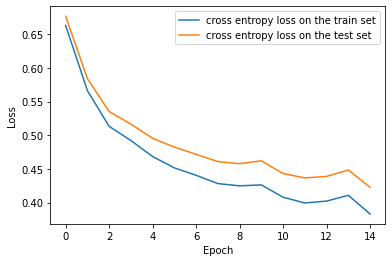

In [82]:
# Train the model
hidden_layers_size =128
input_size = x_train_un.shape[1]
nb_labels = len(class_name)
mlp7 = MLP(LinearLayer(input_size, hidden_layers_size), 
    ReLULayer(),
    LinearLayer(hidden_layers_size, hidden_layers_size),
    ReLULayer(),
    LinearLayer(hidden_layers_size, nb_labels),
    SoftmaxOutputLayer(),
          batch_size=128)
opt = StochasticGradientDescentOptimizer(mlp7, 0.01)
epoch=15
mlp7.fit(opt, x_train_un.to_numpy(), y_train.to_numpy().ravel(), x_test_un.to_numpy(), y_test.to_numpy().ravel(), epoch, nb_labels)

In [83]:
# Predict on the train dataset
y_pred_train_model7 = mlp7.predict(x_train_un.to_numpy())

In [84]:
# Print the accuracy on the train dataset
print('Multiclass accuracy (train):', round(mlp7.multiclass_accuracy(y_train.to_numpy().ravel(),y_pred_train_model7, nb_labels)*100,2), '%')

Multiclass accuracy (train): 86.38 %


In [85]:
# Predict on the test dataset
y_pred_test_model7 = mlp7.predict(x_test_un.to_numpy())

In [86]:
# Print the accuracy on the test dataset
print('Multiclass accuracy (test):', round(mlp7.multiclass_accuracy(y_test.to_numpy().ravel(),y_pred_test_model7, nb_labels)*100,2), '%')

Multiclass accuracy (test): 84.82 %


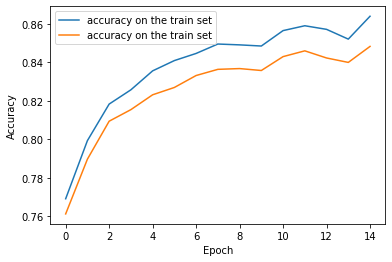

In [87]:
# Plot the evolution of the accuracy over the epochs
plt.plot(mlp7.epoch_accuracy_train, label = "accuracy on the train set")
plt.plot(mlp7.epoch_accuracy_test, label = "accuracy on the train set")
plt.legend(loc = 0)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## CNN from PyTorch

In [161]:
# Import necessary PyTorch modules
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [162]:
# Compute the pixel intensity standard deviation and mean for the test and train datasets
avg_train = np.average(x_train_un.to_numpy())
avg_test = np.average(x_test_un.to_numpy())
std_train = np.std(x_train_un.to_numpy())
std_test = np.std(x_test_un.to_numpy())

In [163]:
# Plot the obtained values
avg_train, avg_test, std_train, std_test

(0.2860405969887955,
 0.2868492807122849,
 0.35302424451492237,
 0.35244415324744005)

In [164]:
# Import the dataset from torchvision
train_set = torchvision.datasets.FashionMNIST(
root = './data/FashionMNIST',
download = True,
train = True,
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(avg_train, std_train)]))

test_set = torchvision.datasets.FashionMNIST(
root = './data/FashionMNIST',
download=True,
train=False,
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(avg_test, std_test)]))

In [165]:
# Define training and testing sets
data_train = DataLoader(train_set,batch_size=256,shuffle=True)
data_train_complete = DataLoader(train_set,batch_size=60000,shuffle=True)
data_test = DataLoader(test_set,batch_size=10000, shuffle=True)

In [167]:
#Build the CNN 
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv_layer_1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3, padding=1), nn.BatchNorm2d(32))
        self.conv_layer_2 = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3), nn.BatchNorm2d(64))
        self.ful_conct_1 = nn.Linear(in_features=64*6*6,out_features=128)
        self.ful_conct_2 = nn.Linear(in_features=128,out_features=128)
        self.out = nn.Linear(in_features=128,out_features=10)
        
    def forward(self,input_data):
        # Convolutional layer 1
        input_data = self.conv_layer_1(input_data)
        input_data = F.relu(input_data)
        input_data = F.max_pool2d(input_data,kernel_size=2,stride=2)
        # Convolutional layer 2
        input_data = self.conv_layer_2(input_data)
        input_data = F.relu(input_data)
        input_data = F.max_pool2d(input_data,kernel_size=2,stride=2)
        # Fully connected layer 1
        input_data = input_data.reshape(-1,64*6*6)
        input_data = self.ful_conct_1(input_data)
        input_data = F.relu(input_data)
        # Fully connected layer 2
        input_data = self.ful_conct_2(input_data)
        input_data = F.relu(input_data)
        # Output layer
        output = self.out(input_data)
        return output

In [168]:
# Set the parameters
epochs = 5
batch_size = 512
learning_rate = 0.002
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = CNN().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [169]:
# Train and test the CNN
epoch_loss_train = []
epoch_loss_test = []
epoch_accuracy_train = []
epoch_accuracy_test = []

for epoch in tqdm(range(0, epochs)): 
    for batch in data_train:
        x_train_cnn,y_train_cnn = batch   
        y_pred_train = cnn(x_train_cnn)
        loss_train = criterion(y_pred_train,y_train_cnn.reshape(-1))        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

    x_train_cnn,y_train_cnn = next(iter(data_train_complete))
    y_pred_train = cnn(x_train_cnn)
    loss_train = criterion(y_pred_train,y_train_cnn.reshape(-1)) 
    epoch_loss_train.append(loss_train)    
    accuracy_train = (y_pred_train.argmax(dim=1).eq(y_train_cnn).sum()/len(train_set)).item()
    epoch_accuracy_train.append(accuracy_train)
    
    
    x_test_cnn,y_test_cnn = next(iter(data_test))
    y_pred_test = cnn(x_test_cnn)
    loss_test = criterion(y_pred_test,y_test_cnn.reshape(-1)) 
    epoch_loss_test.append(loss_test)
    accuracy_test = (y_pred_test.argmax(dim=1).eq(y_test_cnn).sum()/len(test_set)).item()
    epoch_accuracy_test.append(accuracy_test)
                       
    print("epoch", epoch+1, "|loss_train", loss_train, "|accu-train", accuracy_train, "|accu-test", accuracy_test)    

 20%|██        | 1/5 [01:32<06:09, 92.27s/it]

epoch 1 |loss_train tensor(0.2737, grad_fn=<NllLossBackward0>) |accu-train 0.9017999768257141 |accu-test 0.888700008392334


 40%|████      | 2/5 [03:12<04:51, 97.02s/it]

epoch 2 |loss_train tensor(0.2658, grad_fn=<NllLossBackward0>) |accu-train 0.9001666903495789 |accu-test 0.8847000002861023


 60%|██████    | 3/5 [04:55<03:19, 99.86s/it]

epoch 3 |loss_train tensor(0.2049, grad_fn=<NllLossBackward0>) |accu-train 0.9246666431427002 |accu-test 0.9004999995231628


 80%|████████  | 4/5 [06:40<01:41, 101.86s/it]

epoch 4 |loss_train tensor(0.1956, grad_fn=<NllLossBackward0>) |accu-train 0.9294166564941406 |accu-test 0.906499981880188


100%|██████████| 5/5 [17:47<00:00, 213.57s/it]

epoch 5 |loss_train tensor(0.1546, grad_fn=<NllLossBackward0>) |accu-train 0.9424333572387695 |accu-test 0.9156000018119812


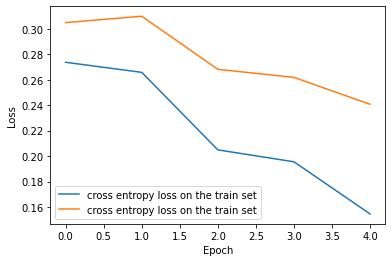

In [170]:
# Plot the evolution of the loss over the epochs
plt.plot(epoch_loss_train, label = "cross entropy loss on the train set")
plt.plot(epoch_loss_test, label = "cross entropy loss on the train set")
plt.legend(loc = 0)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

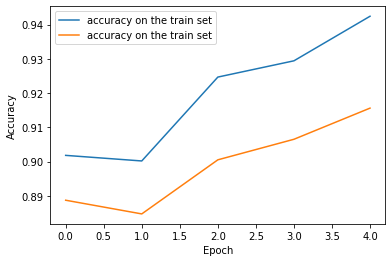

In [171]:
# Plot the evolution of the accuracy over the epochs
plt.plot(epoch_accuracy_train, label = "accuracy on the train set")
plt.plot(epoch_accuracy_test, label = "accuracy on the train set")
plt.legend(loc = 0)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# The proposed MLP

  7%|▋         | 1/15 [00:17<04:11, 17.95s/it]

epoch 1 |loss_train 0.43829490794736303 |accu-train 0.8408833333333333 |accu-test 0.8283


 13%|█▎        | 2/15 [00:35<03:51, 17.80s/it]

epoch 2 |loss_train 0.3688033396033463 |accu-train 0.8680166666666667 |accu-test 0.8518


 20%|██        | 3/15 [00:53<03:33, 17.80s/it]

epoch 3 |loss_train 0.3390511165449418 |accu-train 0.8761166666666667 |accu-test 0.8536


 27%|██▋       | 4/15 [01:11<03:15, 17.77s/it]

epoch 4 |loss_train 0.3095368647337865 |accu-train 0.8881666666666667 |accu-test 0.8638


 33%|███▎      | 5/15 [01:29<02:58, 17.82s/it]

epoch 5 |loss_train 0.28136831823694747 |accu-train 0.89875 |accu-test 0.8689


 40%|████      | 6/15 [01:47<02:40, 17.86s/it]

epoch 6 |loss_train 0.273486190132723 |accu-train 0.9002333333333333 |accu-test 0.8712


 47%|████▋     | 7/15 [02:05<02:23, 17.92s/it]

epoch 7 |loss_train 0.26353279949295066 |accu-train 0.9057 |accu-test 0.8722


 53%|█████▎    | 8/15 [02:22<02:04, 17.79s/it]

epoch 8 |loss_train 0.25849721603904835 |accu-train 0.9058333333333334 |accu-test 0.8706


 60%|██████    | 9/15 [02:40<01:47, 17.98s/it]

epoch 9 |loss_train 0.2605461398897733 |accu-train 0.9025 |accu-test 0.8663


 67%|██████▋   | 10/15 [02:59<01:30, 18.19s/it]

epoch 10 |loss_train 0.24648692670953612 |accu-train 0.9082 |accu-test 0.8691


 73%|███████▎  | 11/15 [03:17<01:12, 18.21s/it]

epoch 11 |loss_train 0.22287214351925372 |accu-train 0.9195833333333333 |accu-test 0.8795


 80%|████████  | 12/15 [03:36<00:54, 18.30s/it]

epoch 12 |loss_train 0.2416875517142371 |accu-train 0.9111 |accu-test 0.8705


 87%|████████▋ | 13/15 [03:55<00:36, 18.46s/it]

epoch 13 |loss_train 0.21407165599762878 |accu-train 0.9218666666666666 |accu-test 0.8774


 93%|█████████▎| 14/15 [04:13<00:18, 18.46s/it]

epoch 14 |loss_train 0.20454621078749813 |accu-train 0.9256833333333333 |accu-test 0.8786


100%|██████████| 15/15 [04:32<00:00, 18.15s/it]

epoch 15 |loss_train 0.197742959151545 |accu-train 0.9293333333333333 |accu-test 0.88


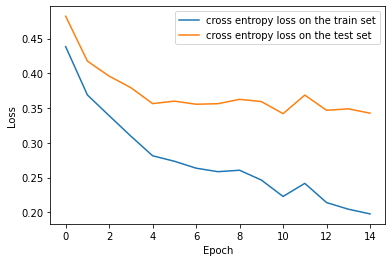

In [88]:
# Train the model
input_size = x_train.shape[1]
nb_labels = len(class_name)
mlp8 = MLP(LinearLayer(input_size, 88), 
    TanHLayer(),
    LinearLayer(88, 30),
    TanHLayer(),
    LinearLayer(30, nb_labels),
    SoftmaxOutputLayer(),
          batch_size=64)
opt = StochasticGradientDescentOptimizer(mlp8, 0.05)
epoch = 15
mlp8.fit(opt, x_train.to_numpy(), y_train.to_numpy().ravel(), x_test.to_numpy(), y_test.to_numpy().ravel(), epoch, nb_labels)

In [89]:
# Predict on the train dataset
y_pred_train_model8 = mlp8.predict(x_train.to_numpy())

In [90]:
# Print the accuracy on the train dataset
print('Multiclass accuracy (train):', round(mlp8.multiclass_accuracy(y_train.to_numpy().ravel(),y_pred_train_model8, nb_labels)*100,2), '%')

Multiclass accuracy (train): 92.93 %


In [91]:
# Predict on the test dataset
y_pred_test_model8 = mlp8.predict(x_test.to_numpy())

In [92]:
# Print the accuracy on the test dataset
print('Multiclass accuracy (test):', round(mlp8.multiclass_accuracy(y_test.to_numpy().ravel(),y_pred_test_model8, nb_labels)*100,2), '%')

Multiclass accuracy (test): 88.0 %


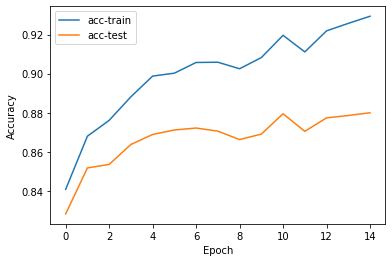

In [93]:
# Plot the evolution of the accuracy over the epochs
plt.plot(mlp8.epoch_accuracy_train, label = "acc-train")
plt.plot(mlp8.epoch_accuracy_test, label = "acc-test")
plt.legend(loc = 0)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Confusion Matrix of CNN and the Proposed MLP

In [172]:
# Create a function to plot the confusion matrix
def conf_mat(y_test, y_pred):
    conf_mat = np.zeros((len(class_name),len(class_name)))
    for i in range(len(y_test)):
        conf_mat[y_pred.argmax(axis=1)[i]][y_test[i]] += 1
    conf_mat_df = pd.DataFrame(conf_mat, columns=class_name, index=class_name)
    plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat_df, annot=True, fmt="g", linewidth=.5)
    plt.xlabel('Predicted', fontsize = 15)
    plt.ylabel('Actual', fontsize = 15)

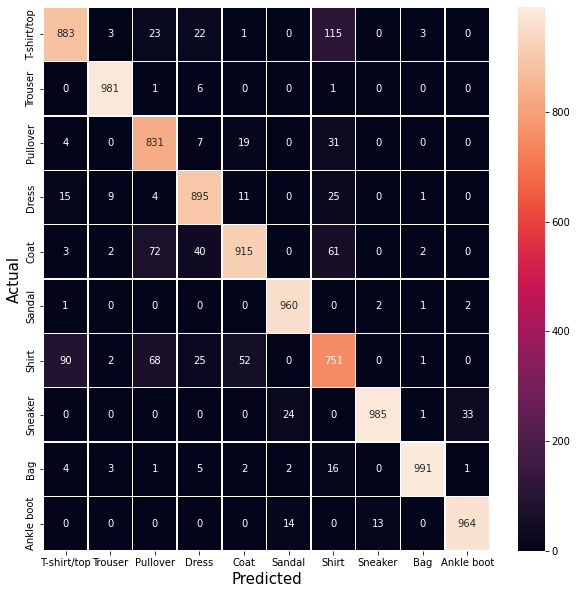

In [173]:
# Plot the confusion matrix for the CNN model
conf_mat(y_test_cnn.detach().numpy().ravel(),y_pred_test.detach().numpy())

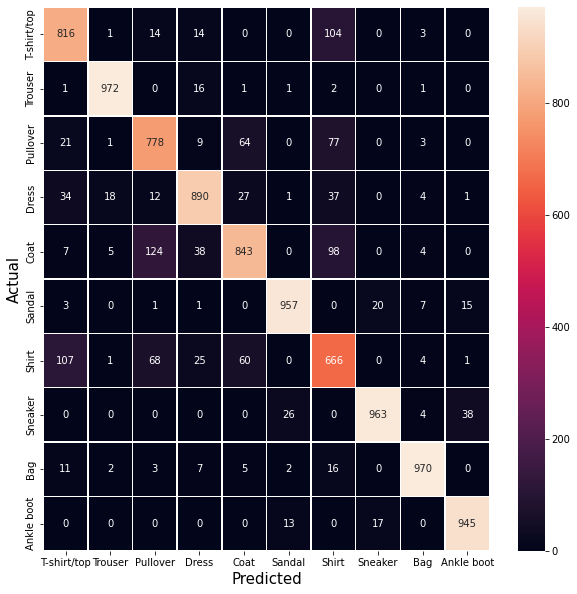

In [174]:
# Plot the confusion matrix for the best MLP model
conf_mat(y_test.to_numpy().ravel(),y_pred_test_model8)